In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import Union, Optional

import sys
sys.path.append('../src')

from utils import nrmse, rsquare
from datasets import mackey_glass_generate, plot_mackey_glass, to_forecasting
from model import ESN

In [2]:
def plot_results(
    y_pred: Union[np.ndarray, torch.Tensor], 
    y_test: Union[np.ndarray, torch.Tensor], 
    start: int = 0, 
    length: int = 500, 
    batch_size: Optional[int] = None
    ) -> None:
    """
    Plots the prediction results.

    Args:
        y_pred (Union[np.ndarray, torch.Tensor]): Predicted values.
        y_test (Union[np.ndarray, torch.Tensor]): True values.
        start (int): Starting index for the samples to plot.
        length (int): Number of samples to plot.
        batch_size (Optional[int]): Batch size. If not provided and input is 3D, first batch [0, :, :] will be used.

    Raises:
    ValueError: If input dimensions are inconsistent.
    """

    # Convert tensors to numpy arrays if necessary
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().detach().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().detach().numpy()
    
    # Handle 3D arrays by selecting the first batch if batch_size is not specified
    if y_pred.ndim == 3:
        if batch_size is None:
            y_pred = y_pred[0, :, :]
            y_test = y_test[0, :, :]
        else:
            y_pred = y_pred[:batch_size, :, :]
            y_test = y_test[:batch_size, :, :]
    elif y_pred.ndim != 2 or y_test.ndim != 2:
        raise ValueError("Input arrays must be 2D or 3D.")
    
    # Ensure start and length are within the array bounds
    end = start + length
    if end > y_pred.shape[0] or end > y_test.shape[0]:
        raise ValueError("Start index and length exceed array dimensions.")

    # Plotting
    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(start, end), y_pred[start:end], lw=3, label="Prediction")
    plt.plot(np.arange(start, end), y_test[start:end], linestyle="--", lw=2, label="True value")
    plt.plot(np.arange(start, end), np.abs(y_test[start:end] - y_pred[start:end]), label="Absolute deviation")
    
    plt.legend()
    plt.show()


In [3]:
TIMESTEPS = 2510
TAU = 17

X = mackey_glass_generate(TIMESTEPS, tau=TAU, seed=5555)
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

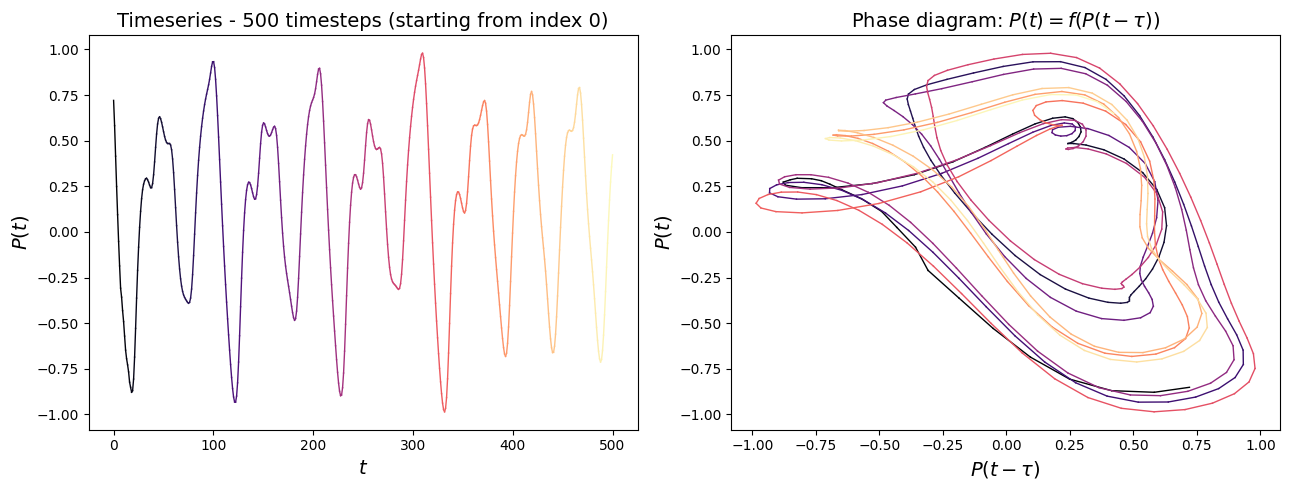

In [4]:
plot_mackey_glass(X, TAU, 500)

In [5]:
x, y = to_forecasting(X, forecast=1)

In [6]:
X_train1, y_train1 = x[:2000], y[:2000]
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1, dtype=torch.float32)

X_test1, y_test1 = x[2000:], y[2000:]
X_test1 = torch.tensor(X_test1, dtype=torch.float32)
y_test1 = torch.tensor(y_test1, dtype=torch.float32)

In [7]:
model = ESN(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    rhow=0.95,
    sparsity=0.2,
    leaky_rate=0.3,
    input_scaling=0.45
)

In [8]:
model.fit(X_train1, y_train1, 0.001)

In [9]:
states = []
predicts = []
batch_size = 10
for i in range(0, X_test1.size(0), batch_size):
    end = i + batch_size
    out, state = model(X_test1[i:end])
    states.append(state)
    predicts.append(out)
    model.update_redaut_lms(X_test1[i:end], y_test1[i:end], 0.001)
    # model.fit(X_test1[i:end], y_test1[i:end])

states = np.concatenate(states, axis=0)
predicts = np.concatenate(predicts, axis=0)

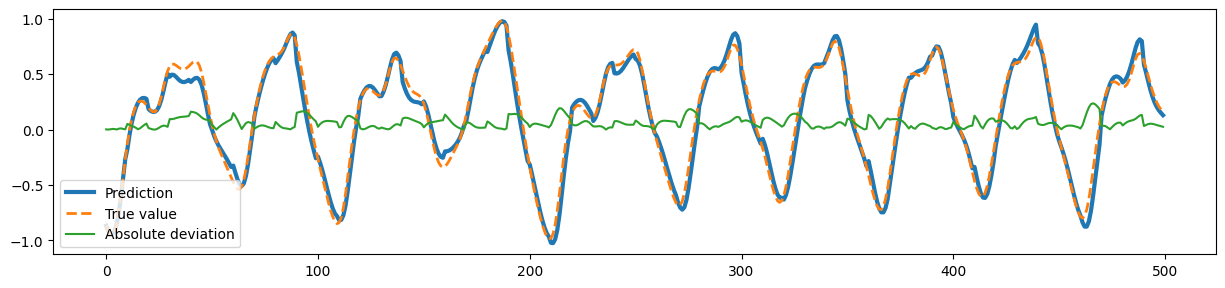

In [10]:
plot_results(predicts, y_test1, length=500)

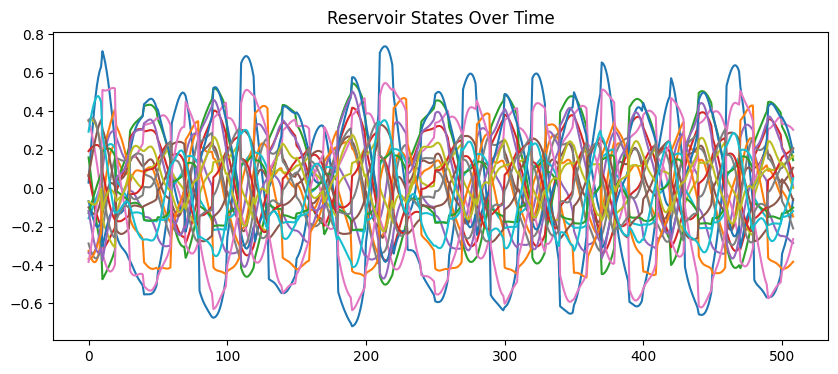

In [11]:
plt.figure(figsize=(10, 4))
for i in range(0, 20):
    plt.plot(states[:, i], label=f'Reservoir neuron {i}')
plt.title("Reservoir States Over Time")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [12]:
rsquare(y_test1, predicts), nrmse(y_test1, predicts)

(0.9759177472442389, 0.038047846094328146)